In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns; sns.set()

df = pd.read_excel('taniguchi_2017_leg.xlsx')

questions = ['Q4_{}'.format(i) for i in np.arange(1,18)]

for i in questions:
    df[i].replace(99,np.nan,inplace=True)


df.loc[:,questions] = KNNImputer().fit_transform(df[questions])

df.head()

,ID,NAME,HABATSU,RESPONSE,PREFEC,DISTRICT,PR,PRBLOCK,PARTY,MINSHIN,...,Q9_6,Q9_7,Q9_8,Q9_9,Q1_1_FA,Q1_2_FA,Q1_3_FA,SQ7_1_1_FA,SQ7_1_2_FA,SQ7_1_3_FA
0,1,船橋＝利実,麻生派,1,1,1,0,51,1,66,...,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN
1,2,道下＝大樹,NaN,1,1,1,0,51,8,2,...,5,5,5,5,経済・雇用,NaN,NaN,NaN,NaN,NaN
2,3,吉川＝貴盛,二階派,1,1,2,0,51,1,66,...,1,1,2,2,NaN,NaN,NaN,NaN,教育の充実,NaN
3,4,金倉＝昌俊,NaN,1,1,2,0,51,3,66,...,5,5,5,5,NaN,NaN,消費税10%中止,NaN,NaN,NaN
4,5,小和田＝康文,NaN,1,1,2,0,51,4,66,...,3,1,1,5,NaN,NaN,NaN,NaN,NaN,NaN


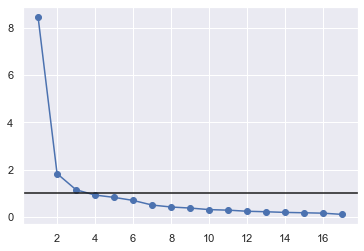

In [4]:
from factor_analyzer import FactorAnalyzer as fa

mod = fa(rotation=None).fit(df[questions])

plt.plot(np.arange(1,18,1),mod.get_eigenvalues()[0],marker='o')
plt.axhline(1,color='k')

In [25]:
res = fa(rotation='promax',n_factors=3).fit(df[questions])

for i in np.arange(1,res.n_factors+1):
    df['factor{}'.format(i)] = res.transform(df[questions].fillna(3))[:,i-1]

df[['factor{}'.format(i) for i in np.arange(1,res.n_factors+1)]].corr()

,factor1,factor2,factor3
factor1,1.000000,-0.071825,-0.793248
factor2,-0.071825,1.000000,-0.062664
factor3,-0.793248,-0.062664,1.000000


Text(0.5, 1.0, 'Japanese 2017 general election candidates by political party and ideological position')

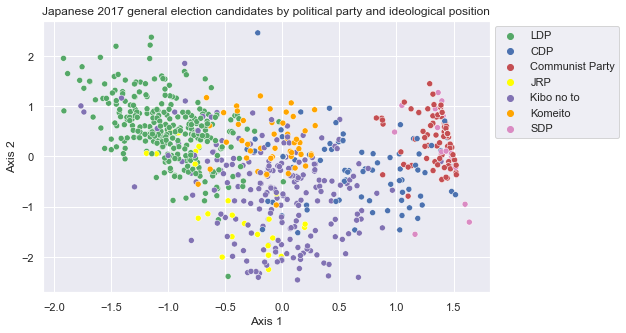

In [6]:
df['party'] = df['PARTY'].replace(np.arange(1,12),['LDP','Komeito','Communist Party','JRP','SDP',np.nan,'Kibo no to','CDP',np.nan,np.nan,np.nan])
plt.figure(figsize=(8,5))
sns.scatterplot(x='factor1',y='factor2',hue='party',data=df,palette=['C2','C0','C3','yellow','C4','orange','C6'])
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Japanese 2017 general election candidates by political party and ideological position')

In [9]:
table = pd.pivot_table(df,index='HABATSU',values=['factor{}'.format(i) for i in np.arange(1,res.n_factors+1)])

df['habatsu'] = df['HABATSU'].replace(['無派閥','竹下派','岸田派','谷垣グループ','石破派','麻生派','二階派','菅グループ','石原派','細田派'],['mu','takeshita','kishida','tanigaki','ishiba','aso','nikai','suga','ishihara','hosoda'])

table.sort_values('factor1')

,factor1,factor2,factor3
HABATSU,,,
菅グループ,-1.158167,0.453521,0.396965
細田派,-1.066644,0.525392,0.522794
石原派,-1.022664,0.503703,0.473896
岸田派,-1.013523,0.489094,0.309660
麻生派,-0.975927,0.461877,0.411491
二階派,-0.961914,0.514997,0.389643
谷垣グループ,-0.904291,0.575140,0.381692
無派閥,-0.885919,0.280813,0.349432
竹下派,-0.850630,0.383080,0.305515


In [17]:
import statsmodels.formula.api as smf

res = smf.ols('factor3 ~ party',df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                factor3   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     589.9
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:27:40   Log-Likelihood:                -297.30
No. Observations:                1018   AIC:                             608.6
Df Residuals:                    1011   BIC:                             643.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.5809      0.037    -15.880      0.000      -0.653      -0.509
party[T.Communist Party]    -0.5133      0.042    -12.190      0.000      -0.596      -0.431
party[T.JRP]                 0.8444      0.058     14.542      0.000       0.730       0.958
party[T.Kibo no to]          0.5973      0.042     14.124      0.000       0.514       0.680
party[T.Komeito]             0.2304      0.058      3.991      0.000       0.117       0.344
party[T.LDP]                 1.0013      0.041     24.621      0.000       0.921       1.081
party[T.SDP]                -0.4975      0.080     -6.232      0.000      -0.654      -0.341
==============================================================================
Omnibus:                      165.389   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              505.816
Skew:                           0.803   Prob(JB):                    1.46e-110
Kurtosis:                       6.057   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
table = df.groupby('party')[['factor1','factor2','factor3']].mean().reset_index()
table

,party,factor1,factor2,factor3
0,CDP,0.634657,-0.241034,-0.580931
1,Communist Party,1.404071,0.455895,-1.094255
2,JRP,-0.264704,-1.483932,0.263444
3,Kibo no to,-0.061095,-0.745426,0.016324
4,Komeito,-0.092698,0.279372,-0.350539
5,LDP,-0.952318,0.489902,0.420366
6,SDP,1.404614,0.117699,-1.078440


<AxesSubplot:xlabel='factor1', ylabel='factor2'>

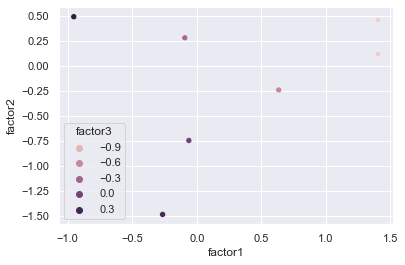

In [22]:
sns.scatterplot(x='factor1',y='factor2',hue='factor3',data=table)

In [29]:
pd.DataFrame(res.loadings_,columns=[f'factor{i}' for i in range(1,4)],index=questions).to_csv('loadings_3dimensions.csv')